In [1]:
import os
from sklearn.decomposition import PCA
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import umap
import warnings
from collections import Counter

from src.utils import *

# Suppress warnings
warnings.filterwarnings("ignore")

In [7]:
os.listdir(FEATURES_PATH)

['labels_27.npy', 'volume_features_27.npy']

In [8]:
# Loading the features from the features path
volume_features_path = os.path.join(FEATURES_PATH, 'volume_features_27.npy')
labels_path = os.path.join(FEATURES_PATH, 'labels_27.npy')

# Load the extracted features and labels
if os.path.exists(volume_features_path) and os.path.exists(labels_path):
    volume_features = np.load(volume_features_path)
    labels = np.load(labels_path)
else:
    print("Volume features or labels not found")

In [9]:
print("Volume features shape:", volume_features.shape)
print("Labels shape:", labels.shape)

# Get the distribution of the labels
Counter(labels)

Volume features shape: (400, 768)
Labels shape: (400,)


Counter({-1: 190,
         9: 15,
         7: 15,
         13: 15,
         12: 15,
         1: 15,
         4: 15,
         6: 15,
         5: 15,
         8: 15,
         2: 15,
         10: 15,
         0: 15,
         3: 15,
         11: 15})

In [ ]:
palette1 = [
    '#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', 
    '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#800000', '#aaffc3', 
    '#808000', '#ffd8b1', '#000075', 
]
palette2 = [
    '#e6194b', '#3cb44b',
    "#6b8e23", "#a0522d",
    "#4b0082", "#ff0000", "#00ced1",
    "#ffa500", "#ffff00", "#00ff00",
    "#00fa9a", "#0000ff", "#ff00ff",
    "#1e90ff", "#ffe4b5", "#ff69b4"
]
palette3 = [
    '#a6cee3', '#1f78b4', '#b2df8a',
    '#33a02c', '#fb9a99', '#e31a1c', 
    '#fdbf6f', '#ff7f00', '#cab2d6',
    '#6a3d9a', '#ffff99', '#b15928',
    '#564bbf', '#de438e'
]

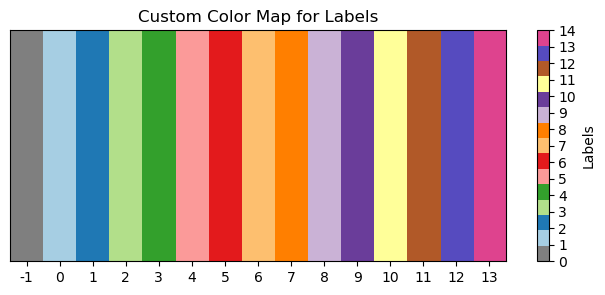

In [172]:
# Create a color map for the labels
# Create a copy of the colormap
# base_cmap = plt.cm.get_cmap('turbo', len(np.unique(labels)) - 1)  # -1 because we handle -1 separately
base_cmap = mcolors.ListedColormap(palette3)

# Create a custom colormap with grey for -1
colors = np.vstack(
    (np.array([0.5, 0.5, 0.5, 1]),  # Grey for -1
    base_cmap(np.linspace(0, 1, len(np.unique(labels)) - 1))))
custom_cmap = mcolors.ListedColormap(colors)
# Plot the color map
plt.figure(figsize=(8, 3))
plt.imshow([np.arange(len(np.unique(labels)))], aspect='auto', cmap=custom_cmap)
plt.xticks(np.arange(len(np.unique(labels))), np.unique(labels))
plt.yticks([])
plt.title("Custom Color Map for Labels")
plt.colorbar(ticks=np.arange(len(np.unique(labels))), label='Labels')
plt.show()

# PCA

In [180]:
def plot_PCA(features_pca, labels, save_name=None, unlabeled=True):
    """
    Create a PCA plot for the given features extracted from the 3D volumes
    :param features_pca: PCA transformed features
    :param labels: list of labels for the features (-1 indicates no label)
    :param save_name: name of the figure to save, if None the figure will be shown
    :param cmap: colormap to use for the labels
    :param unlabeled: if set to False plot just the points with the given label (not -1), otherwise plot all the data points
    """
    
    # Split the data into labeled and unlabeled
    unlabeled_mask = labels == -1
    labeled_mask = ~unlabeled_mask
    
    plt.figure(figsize=(10, 8))
    
    if unlabeled:
        # Plot also unlabeled points
        if np.any(unlabeled_mask):
            plt.scatter(
                features_pca[unlabeled_mask, 0], 
                features_pca[unlabeled_mask, 1],
                c='black', s=25, alpha=0.2,  # Lower alpha for unlabeled points
                label='Unlabeled'
            )
        
    # Plot labeled points with higher alpha
    if np.any(labeled_mask):
        scatter = plt.scatter(
            features_pca[labeled_mask, 0], 
            features_pca[labeled_mask, 1],
            c=labels[labeled_mask], cmap=base_cmap, s=35, alpha=0.8,  # Higher alpha for labeled points
        )
    
    # Create colorbar with proper ticks (only for labeled data)
    cbar = plt.colorbar(
        scatter, 
        label='Labels', 
        ticks=np.unique(labels[labeled_mask]))
    
    plt.grid()
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title('PCA of 3D CNN Features')
    plt.legend()
    
    if save_name:
        # Save the figure
        plt.savefig(os.path.join(FIGURES_DIR, save_name))
        print(f"Figure saved as {save_name}")
    else:
        plt.show()

In [174]:
# 3. Use PCA to reduce dimensionality to 2D
pca = PCA(n_components=2)
pca.fit(volume_features)
volume_features_pca = pca.transform(volume_features)
print(f"Reduced features shape: {volume_features_pca.shape}")
print(f"Reduced features:\n{volume_features_pca[:3]}")

Reduced features shape: (400, 2)
Reduced features:
[[-1.1560427  -0.13018274]
 [-1.0659593   0.73503435]
 [-1.5706526   0.37604868]]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


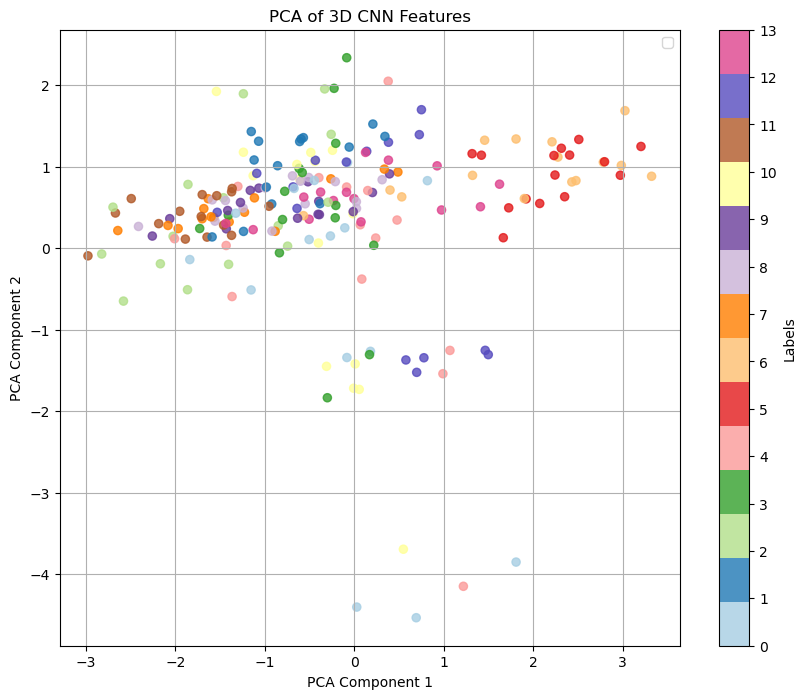

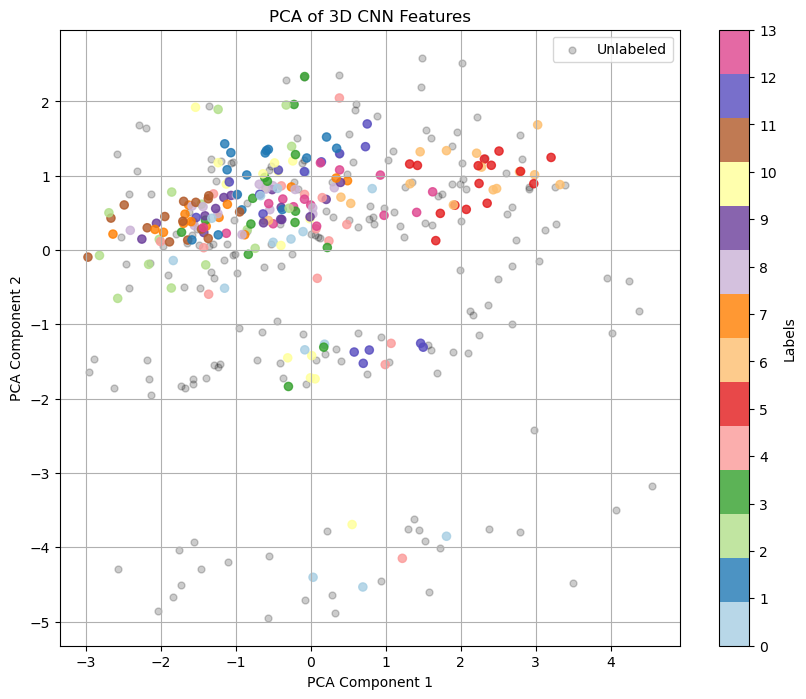

In [181]:
plot_PCA(volume_features_pca, labels, unlabeled=False)
plot_PCA(volume_features_pca, labels, unlabeled=True)

# PCA (keep 95% variance) -> TSNE (2D) -> plot

**t-SNE** is a non-linear dimensionality reduction technique that is particularly well-suited for visualizing high-dimensional data in a low-dimensional space (typically 2D or 3D). It works by converting the similarities between data points into joint probabilities and then minimizing the divergence between these probabilities in the high-dimensional and low-dimensional spaces.
https://distill.pub/2016/misread-tsne/


In [32]:
pca = PCA(n_components=0.80)  # Keep 95% of variance
pca_features = pca.fit_transform(volume_features)
print(f"PCA reduced dimensions from {volume_features.shape[1]} to {pca_features.shape[1]}")

PCA reduced dimensions from 768 to 3


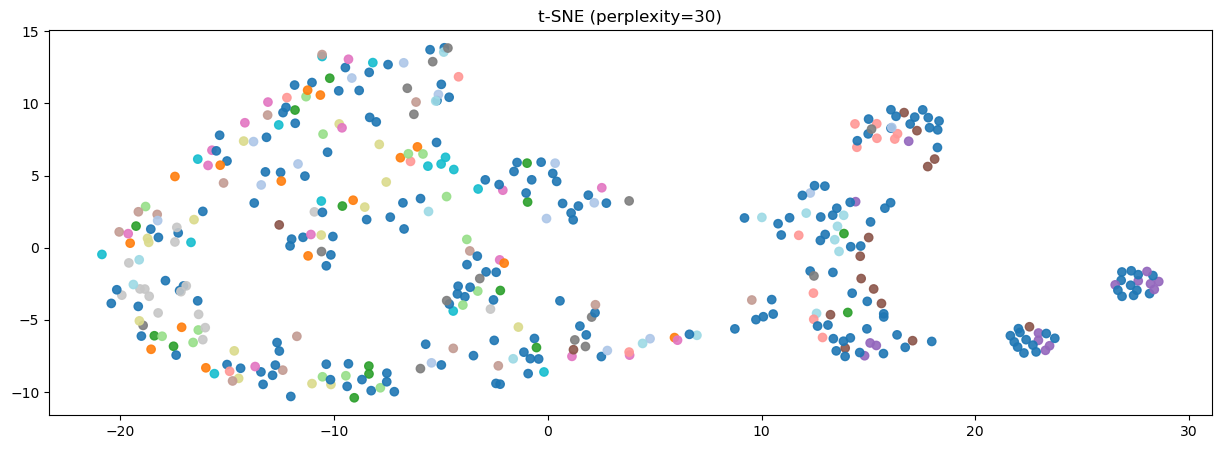

In [34]:
# 2. t-SNE with different parameters
# Perplexities are a hyperparameter for t-SNE that affects the balance between local and global aspects of the data
# perplexities = [5, 30, 50]
perplexities = [30]


fig, axes = plt.subplots(1, len(perplexities), figsize=(15, 5))
if len(perplexities) == 1:
    axes = [axes]  # Make sure axes is iterable

for i, perp in enumerate(perplexities):
    tsne = TSNE(n_components=2, perplexity=perp, random_state=42)
    tsne_result = tsne.fit_transform(pca_features)
    scatter = axes[i].scatter(
        tsne_result[:, 0], tsne_result[:, 1], 
        c=labels, alpha=0.9, cmap='tab20')
    axes[i].set_title(f't-SNE (perplexity={perp})')

# UMAP

Uniform Manifold Approximation and Projection for Dimension Reduction

In [109]:
subset_length = 400
volume_features_subset = volume_features[:subset_length]
labels_subset = labels[:subset_length]

# Fit X into an embedded space and return that transformed output
emb2d = umap.UMAP(
    n_neighbors=30, min_dist=0.1).fit_transform(volume_features_subset)

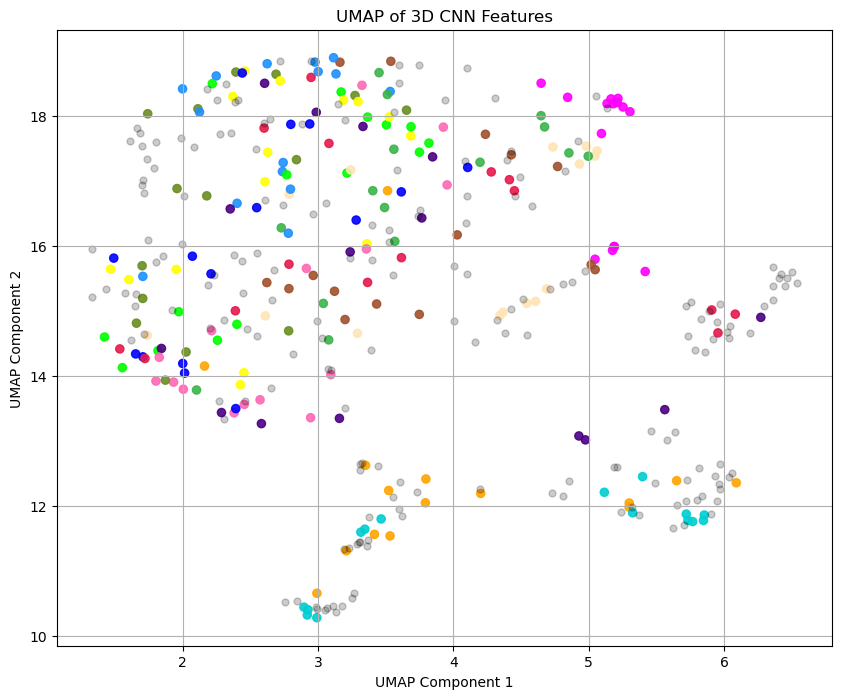

In [110]:
plt.figure(figsize=(10, 8))
# First plot the points with label non-equal to -1
plt.scatter(
    emb2d[labels_subset != -1, 0], 
    emb2d[labels_subset != -1, 1], 
    c=labels_subset[labels_subset != -1], 
    cmap=base_cmap, s=35, alpha=0.9
)
# Then plot the points with label -1
plt.scatter(
    emb2d[labels_subset == -1, 0], 
    emb2d[labels_subset == -1, 1], 
    c='black', s=25, alpha=0.2
)
plt.title('UMAP of 3D CNN Features')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.grid()
plt.show()

# Tiny Supervised Baseline

Use logistic regression as a baseline classifier on the encoder output of the autoencoder.

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
# Data: volume_features, labels

# Create the dataset for logistic regression classification (only labeled data)
volume_features_labeled = volume_features[labels != -1]
labels_labeled = labels[labels != -1]
print(f"Total number of labeled samples: {len(labels_labeled)}")

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    volume_features_labeled, labels_labeled, 
    test_size=0.2, random_state=42, stratify=labels_labeled
)

print(f"\nX_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

Total number of labeled samples: 210

X_train shape: (168, 768)
X_test shape: (42, 768)


In [ ]:
# Create a logistic regression model
model = LogisticRegression(
    max_iter=1000, 
    random_state=42)
# Fit the model to the training data
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [30]:
# Make predictions on the test data
y_pred = model.predict(X_test)
print(y_pred.shape)

# Get the metric scores
report = classification_report(
    y_true=y_test, y_pred=y_pred)
print(report)

(42,)
              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       1.00      0.67      0.80         3
           2       0.75      1.00      0.86         3
           3       1.00      1.00      1.00         3
           4       0.50      0.67      0.57         3
           5       1.00      0.33      0.50         3
           6       1.00      1.00      1.00         3
           7       0.33      0.33      0.33         3
           8       0.33      0.33      0.33         3
           9       0.67      0.67      0.67         3
          10       1.00      1.00      1.00         3
          11       0.60      1.00      0.75         3
          12       1.00      0.67      0.80         3
          13       0.75      1.00      0.86         3

    accuracy                           0.74        42
   macro avg       0.78      0.74      0.73        42
weighted avg       0.78      0.74      0.73        42



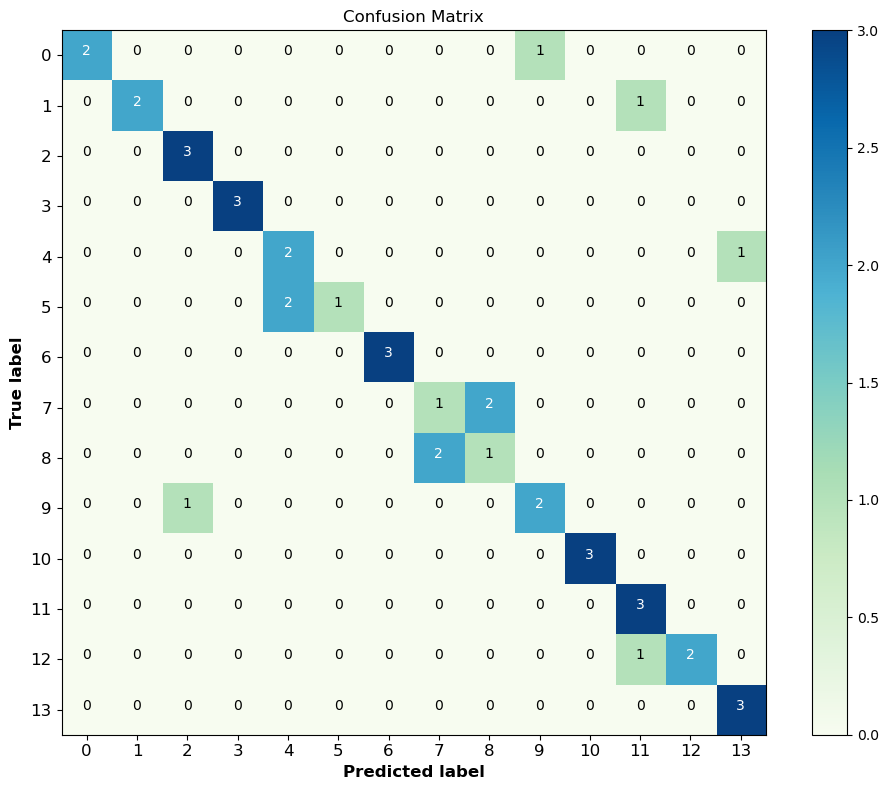

In [ ]:
# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.GnBu)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(np.unique(labels_labeled)))

plt.xticks(tick_marks, np.unique(labels_labeled), fontsize=12)
plt.yticks(tick_marks, np.unique(labels_labeled), fontsize=12)

# Add text annotations (numbers) to the confusion matrix
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(
        j, i, cm[i, j], 
        horizontalalignment="center", 
        color="white" if cm[i, j] > thresh else "black")
    
plt.ylabel('True label', fontsize=12, fontweight='bold')
plt.xlabel('Predicted label', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()


## Graph-based Label Propagation
 Label Propagation spreads label information from the labeled nodes to the unlabeled ones by iteratively averaging the labels of neighbors.

In [ ]:
from sklearn.semi_supervised import LabelPropagation
from sklearn.neighbors import kneighbors_graph

LabelPropagation()

In [ ]:
# Create the graph: Nodes = all samples. Edges = similarity (e.g., k-NN with cosine or Euclidean distance
# and fit the features

# Fit label propagation
label_prop = LabelPropagation(
    kernel='knn', 
    n_neighbors=15, 
    max_iter=1000)

label_prop.fit(X=volume_features, y=labels)


LabelPropagation(kernel='knn', n_neighbors=15)

In [116]:
# Extract predicted labels and discern between already labelled and previously unlabelled

# The .transduction_ attribute gives predicted labels for all input samples, including those that were already labeled
# label_prop.transduction_          -> Final label for each point
# label_prop.label_distributions_   -> Shape: (n_samples, n_classes), probability per each class

unlabeled_mask = labels == -1
labeled_mask = labels != -1

# Get the indices of the initially unlabelled and labelled data points
pseudo_labels_unlabeled = label_prop.transduction_[unlabeled_mask]
pseudo_labels_labeled = label_prop.transduction_[labeled_mask]

print(f"Unlabeled Pseudo Labels: {pseudo_labels_unlabeled.shape}")
print(f"Labeled Pseudo Labels: {pseudo_labels_labeled.shape}")

confidences_unlabeled = label_prop.label_distributions_[unlabeled_mask].max(axis=1)
confidences_labeled = label_prop.label_distributions_[labeled_mask].max(axis=1)

print(f"Unlabeled Confidences: {confidences_unlabeled.shape}")
print(f"Labeled Confidences: {confidences_labeled.shape}")

Unlabeled Pseudo Labels: (190,)
Labeled Pseudo Labels: (210,)
Unlabeled Confidences: (190,)
Labeled Confidences: (210,)


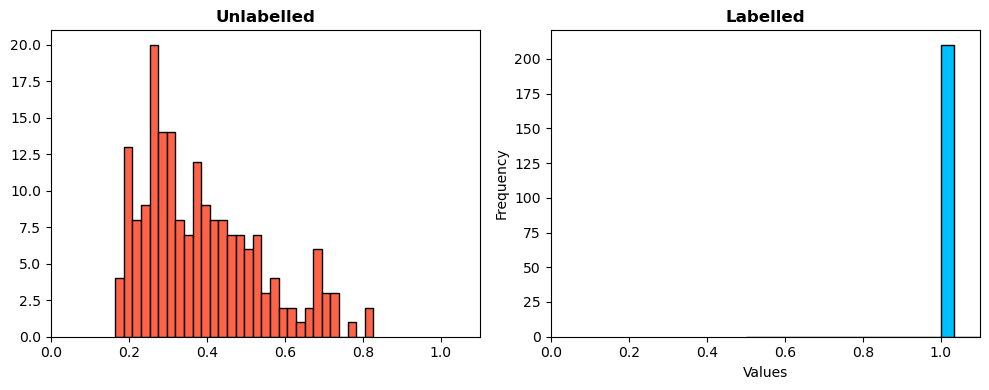

In [125]:
# Plot the confidence score distributions based on the feature type

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# 1. New predictions (on the initially unlabeled dataset)
axes[0].hist(confidences_unlabeled, bins=30, color='tomato', edgecolor='black')
axes[0].set_xlim([0, 1.1])
axes[0].set_title("Unlabelled", fontweight='bold')

# 2. Already existing predictions
axes[1].hist(confidences_labeled, bins=30, color='deepskyblue', edgecolor='black')
axes[1].set_xlim([0, 1.1])
axes[1].set_title("Labelled", fontweight='bold')
 
# Adding labels and title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

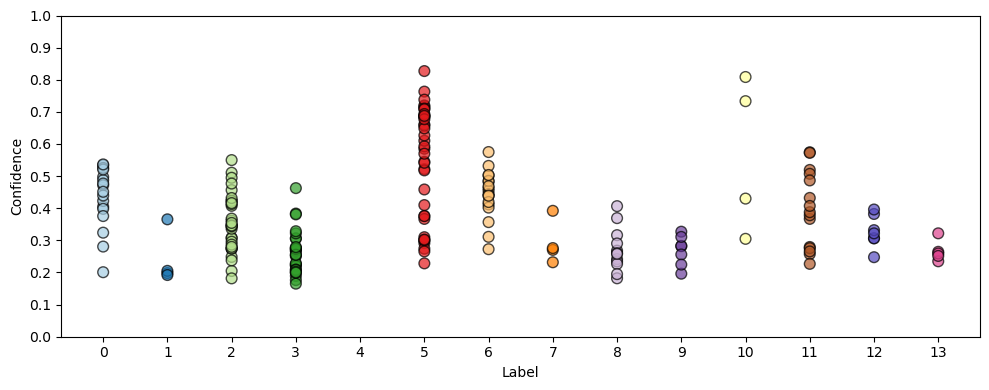

In [200]:
# Create the scatterplot showing the predicted label distribution and their confidences
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

ax.scatter(
    x=pseudo_labels_unlabeled, y=confidences_unlabeled, 
    c=pseudo_labels_unlabeled, cmap=base_cmap, alpha=0.7,
    s=60, edgecolors='black'
)
# Adding labels and title
plt.xlabel('Label')
plt.ylabel('Confidence')
ax.set_xticks([i for i in range(14)])
ax.set_yticks([i / 10 for i in range(11)])
plt.tight_layout()
plt.show()


In [95]:
# Compute 2D projection
embedding = umap.UMAP(
    n_neighbors=15, min_dist=0.1, metric='cosine').fit_transform(volume_features)
print(embedding.shape)

(400, 2)


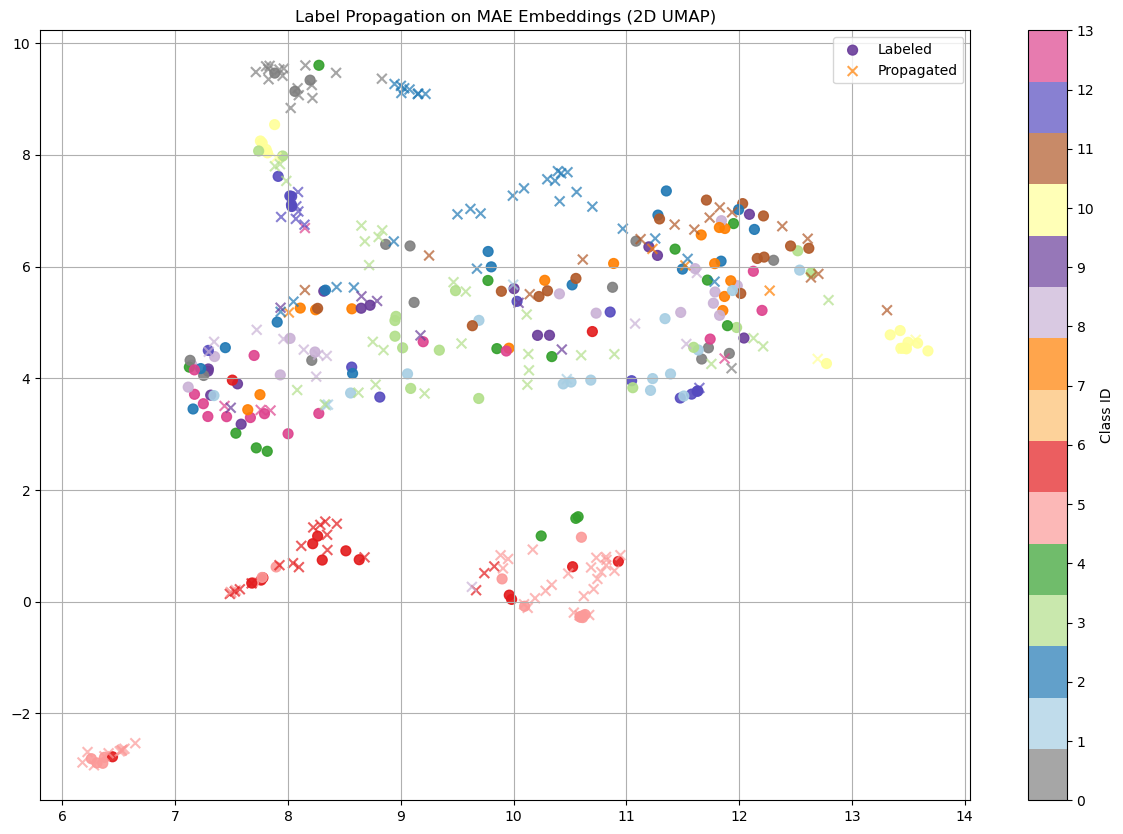

In [199]:
# Plot
plt.figure(figsize=(15, 10))

# Plot original LABELED samples with true labels
plt.scatter(
    x=embedding[labeled_mask, 0], 
    y=embedding[labeled_mask, 1],
    c=labels[labeled_mask], 
    cmap=custom_cmap, marker='o', label='Labeled', alpha=0.9, s=50)

# Plot UNLABELED samples with their propagated pseudo-labels
plt.scatter(
    x=embedding[unlabeled_mask, 0], 
    y=embedding[unlabeled_mask, 1],
    c=pseudo_labels_unlabeled, 
    cmap=custom_cmap, marker='x', label='Propagated', alpha=0.7, s=50)

plt.grid()
plt.legend()
plt.title("Label Propagation on MAE Embeddings (2D UMAP)")
plt.colorbar(ticks=np.arange(len(np.unique(labels))), label='Class ID')